In [1]:
import numpy as np
import os

In [5]:
cwd = './results/shunqing/5s_res_norm'
files = [file for file in os.listdir(cwd) if file.endswith('.npy')]
events = set(['_'.join(file.split('_')[:2]) for file in files])

In [6]:
errs = []
for event in events:
    true = np.load(os.path.join(cwd,event+'_true.npy'))
    pred = np.load(os.path.join(cwd,event+'_pred.npy'))
    err = true - pred
    errs.append(err)

In [15]:
err.shape

(557, 5, 105, 3)

In [13]:
import matplotlib.pyplot as plt

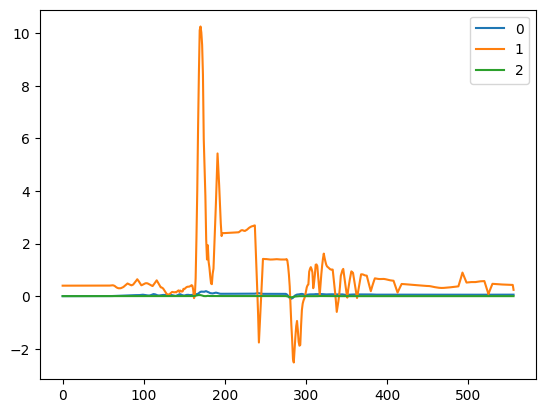

In [21]:
# true = np.load(os.path.join(cwd,event+'_true.npy'))
for i in range(3):
    plt.plot(err.mean(axis=1).mean(axis=1)[:,i],label=i)
    plt.legend()

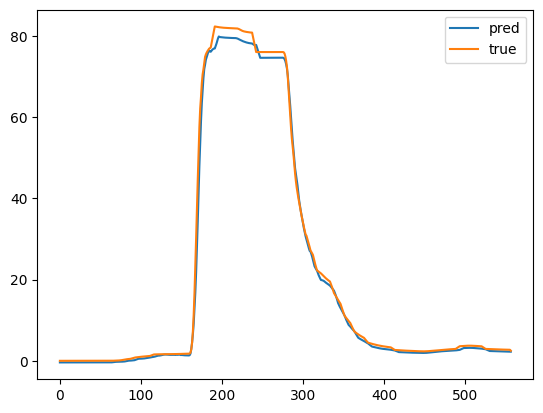

In [27]:
plt.plot(pred.mean(axis=1).mean(axis=1)[:,1],label='pred')
plt.plot(true.mean(axis=1).mean(axis=1)[:,1],label='true')
plt.legend()

In [4]:
train_loss = np.load('./model/shunqing/train_loss.npy')
test_loss = np.load('./model/shunqing/train_loss.npy')


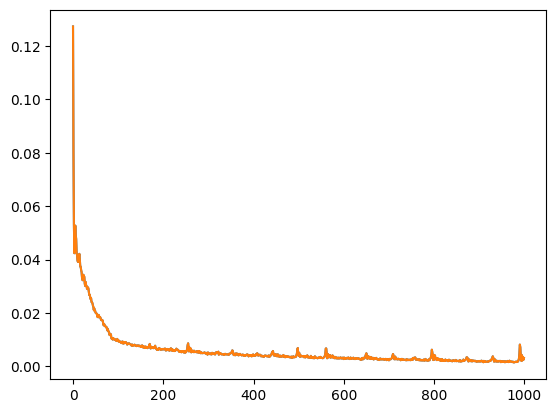

In [6]:
plt.plot(train_loss)
plt.plot(test_loss)